# Scaling in electric load profiles
## Description
This notebook presents initial analysis by Jonathan Lee and Mohini Bariya at UC Berkeley on the statistical characteristics of electric load profiles in different contexts, and how these characteristics scale as load profiles are aggregated. This research is motivated by its application to three broader research questions in engineering decentralized power systems:
1. Understanding and quantifying demand-side economies of scale in load diversity and aggregation
2. Modeling load profiles as a stochastic process for short-term forecasting
3. Modeling load profiles as a stochastic process for system design and long-term reliability studies

We analyze two data sets in different contexts: An island mini-grid in rural Uganda provided by [New Sun Road, Public Benefit Corporation](https://www.newsunroad.com/), and residential homes from the [Austin, TX, USA Pecan Street Project](https://www.pecanstreet.org/). We chose these two sets because they are free, have high resolution (<1 hr), and that by being from such different contexts they can provide insight into what characteristics are likely to be universally vs. locally true. For both, we look at one month of power consumption data sampled at one-minute resolution.

At this point, our initial analysis consists of visualizing some basic statistics of individual and aggregate load profiles to build intuition, and looking in some depth at load factor. We show how aggregate load factor scales with the number of users in both contexts, and how this translates to an economy of scale in the capacity of a decentralized system. We also look at a "generalized load factor" wich we define as the ratio of the average power demand to the x'th percentile of power demand, and the scaling of these factors. This generalized load factor allows us to compute the capacity required to meet power demand x percent of the time.

## Setup

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import imp
from AggregateStatisticCalculator import AggregateStatisticCalculator
from AggregateStatisticCalculator_Pecan import *
plt.style.use('ggplot')

## Sample Load Profile Visualization

First, to get a sense for the power consumption we just look at the mean load (in time) per user against the number of users. Since for each $k$ users there are many possible aggregate load profiles to choose from, there will be a distribution of values over the samples for $k$. We generally take on the order of hundreds of samples.

In [ ]:
# Pecan data
NPecan = 35;
dataPecan = pd.read_pickle('PecanSt_35loads_minRez');
nPecan = np.arange(1, NPecan); statList = [meanTotalLoadPerUser, cvLoad, loadFactor]
statsPecan = aggLoadStats(dataPecan.T, nPecan, statList, samplesPerLevel=500, verbose=True);

<IPython.core.display.Javascript object>


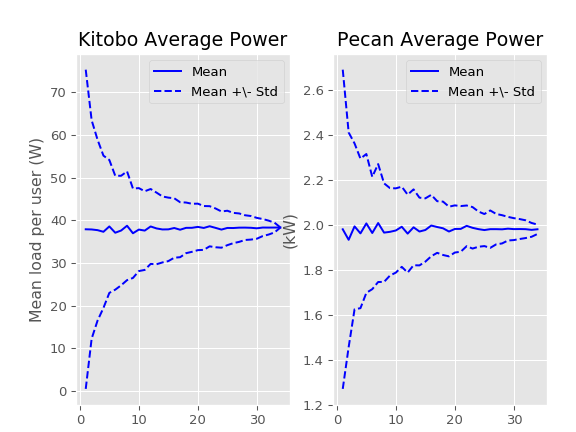

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True)
plt.sca(ax1)

# Get Kitobo data
ascKitobo = AggregateStatisticCalculator('kitobo','minute','loadFactor')
ascKitobo.connect()
totalStatsKitobo = ascKitobo.getSamplesByNumberUsers(['avg', 'loadFactor'])  # Get sample statistics of aggregate profiles (min, max, cnt, avg)
ascKitobo.disconnect()
NKitobo = len(totalStatsKitobo)

meanLoadPerUserKitobo = np.zeros(NKitobo) #  [[t['avg']/(k+1) for t in totalStats[k]] for k in range(len(totalStats))]
meanLoadPerUserPlusStdKitobo = np.zeros(NKitobo)
meanLoadPerUserMinusStdKitobo = np.zeros(NKitobo)
for k in range(NKitobo):
    x = [t['avg']/(k+1) for t in totalStatsKitobo[k]]
    s = np.std(x)
    meanLoadPerUserKitobo[k] = np.mean(x)
    meanLoadPerUserPlusStdKitobo[k] = meanLoadPerUserKitobo[k]+s
    meanLoadPerUserMinusStdKitobo[k] = meanLoadPerUserKitobo[k]-s
n = range(1, NKitobo+1)
# Plot mean load against number of users
plt.plot(n, meanLoadPerUserKitobo, 'b')
plt.plot(n, meanLoadPerUserPlusStdKitobo, 'b--', n, meanLoadPerUserMinusStdKitobo, 'b--')
plt.legend(['Mean','Mean +\- Std'])
plt.ylabel('Mean load per user (W)')
plt.xlabel('Number of users')
plt.title('Kitobo Average Power');


# Pecan street results
plt.sca(ax2)
meanLoadPerUserPecan = np.nanmean(statsPecan[:, :, 0], axis=1);
sig = np.sqrt(np.nanvar(statsPecan[:, :, 0], axis=1));
meanLoadPerUserPlusStdPecan = meanLoadPerUserPecan + sig;
meanLoadPerUserMinusStdPecan = meanLoadPerUserPecan - sig;

plt.plot(nPecan, meanLoadPerUserPecan, 'b')
plt.plot(nPecan, meanLoadPerUserPlusStdPecan, 'b--', nPecan, meanLoadPerUserMinusStdPecan, 'b--')
plt.legend(['Mean','Mean +\- Std'])
plt.ylabel('(kW)')
plt.xlabel('Number of users')
plt.title('Pecan Average Power');

Next, we look at the coefficient of variation (in time) of $k$ aggregate load profiles, meaning that the samples are the instantaneous power of the aggregate load. Coefficient of variation is related to the predictability of the load profile. We see scaling behavior of $\frac{1}{n}$ to a limit.

<IPython.core.display.Javascript object>


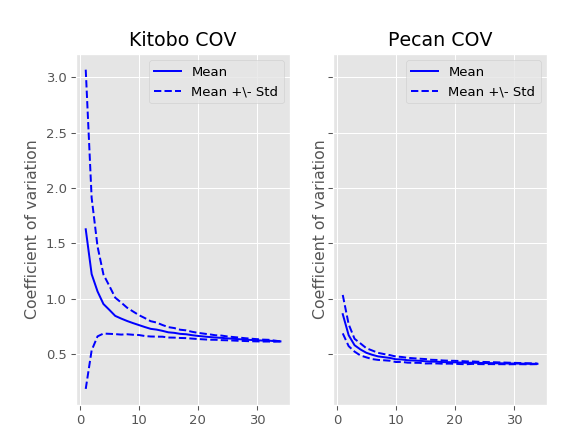

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
plt.sca(ax1)
# Kitobo
asc = AggregateStatisticCalculator('kitobo','minute','cov')
asc.connect()
covs = asc.getSamplesByNumberUsers()
asc.disconnect()

m = np.zeros(len(covs))
mPlusStd = np.zeros(len(covs))
mMinusStd = np.zeros(len(covs))
n = range(1, len(covs)+1)

for k in range(len(covs)):
    m[k] = np.mean(covs[k])
    s = np.std(covs[k])
    mPlusStd[k] = m[k] + s
    mMinusStd[k] = m[k] - s

plt.plot(n, m, 'b')
plt.plot(n, mPlusStd, 'b--', n, mMinusStd, 'b--')
plt.legend(['Mean','Mean +\- Std'])
plt.xlabel('Number of users')
plt.ylabel('Coefficient of variation')
plt.title('Kitobo COV');

# Pecan St. 
cov_pecan = statsPecan[:, :, 1];
m = np.nanmean(cov_pecan, axis=1);
s = np.sqrt(np.nanvar(cov_pecan, axis=1));
plt.sca(ax2)
plt.plot(nPecan, m, 'b')
plt.plot(nPecan, m + s, 'b--', n, m - s, 'b--')
plt.legend(['Mean','Mean +\- Std'])
plt.xlabel('Number of users')
plt.ylabel('Coefficient of variation')
plt.title('Pecan COV');

## Load Factor
Load factor vs aggregation level

Generalized load factor vs aggregation level

Mean load factor across samples vs percentile, multiple lines for N=5,10,15.

<IPython.core.display.Javascript object>


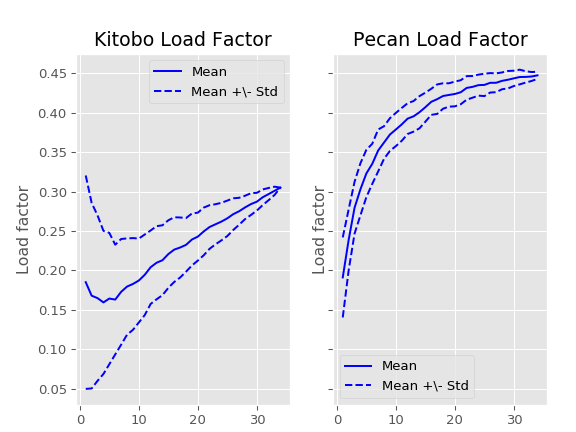

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
plt.sca(ax1)

asc = AggregateStatisticCalculator('kitobo','minute','loadFactor')
asc.connect()
lfs = asc.getSamplesByNumberUsers()  # Get samples of load factor of aggregate profiles
asc.disconnect()

m = np.zeros(len(lfs))
mPlusStd = np.zeros(len(lfs))
mMinusStd = np.zeros(len(lfs))
n = range(1, len(lfs)+1)

for k in range(len(lfs)):
    m[k] = np.mean(lfs[k])
    s = np.std(lfs[k])
    mPlusStd[k] = m[k] + s
    mMinusStd[k] = m[k] - s

plt.plot(n, m, 'b')
plt.plot(n, mPlusStd, 'b--', n, mMinusStd, 'b--')
plt.legend(['Mean','Mean +\- Std'])
plt.xlabel('Number of users')
plt.ylabel('Load factor')
plt.title('Kitobo Load Factor');

# Pecan St. 
plt.sca(ax2)
lf_pecan = statsPecan[:, :, 2];
m = np.nanmean(lf_pecan, axis=1);
s = np.sqrt(np.nanvar(lf_pecan, axis=1));
plt.plot(nPecan, m, 'b')
plt.plot(nPecan, m + s, 'b--', nPecan, m - s, 'b--')
plt.legend(['Mean','Mean +\- Std'])
plt.xlabel('Number of users')
plt.ylabel('Load factor')
plt.title('Pecan Load Factor');

In [ ]:
# Generalized Load factor vs aggregation level
percentiles_array = np.arange(60, 100, 5)
statArgs = []
statList = []
for p in percentiles_array:
    statArgs.append([p]);
    statList.append(genLoadFactor)

R = aggLoadStats(dataPecan.T, nPecan, statList, statArgs=statArgs, samplesPerLevel=200, verbose=True);

<IPython.core.display.Javascript object>


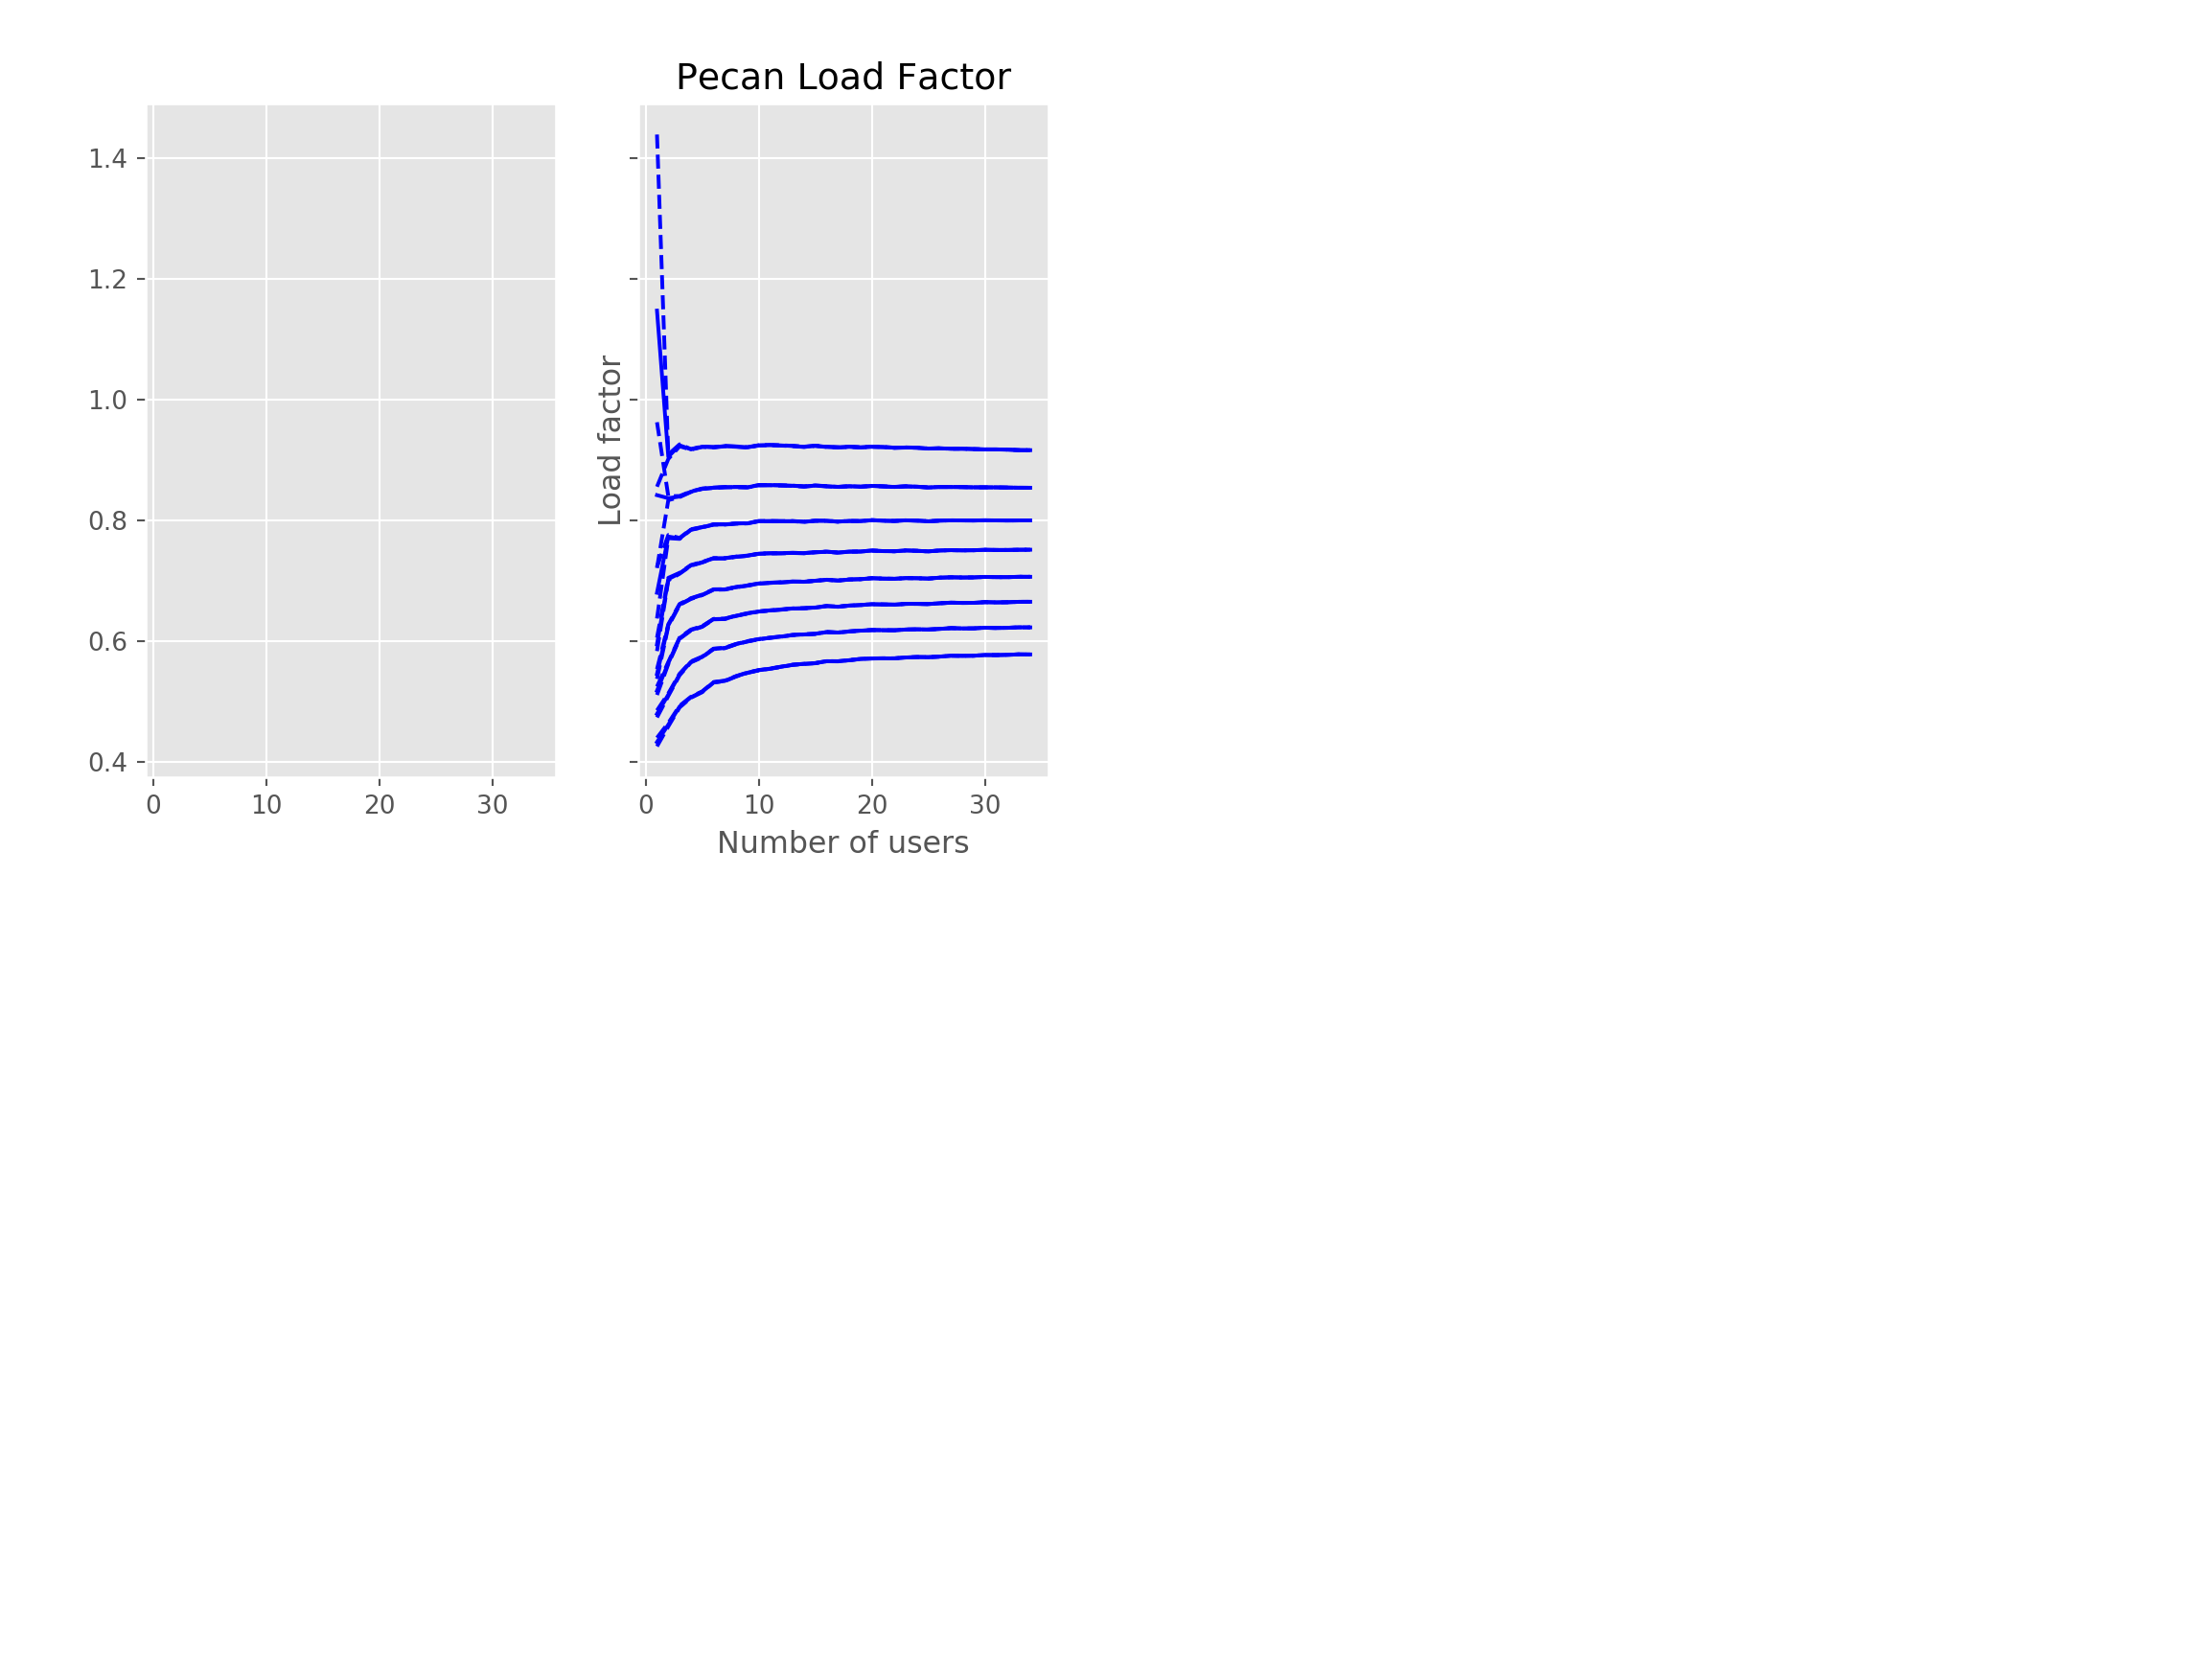

In [23]:
# Generalized load factor versus aggregation level. 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
plt.sca(ax1)

plt.sca(ax2);
muGLF = np.nanmean(R, axis=1);
sGLF = np.nanvar(R, axis=1);

for i in range(np.size(percentiles_array)):
    m = muGLF[:, i]; s = sGLF[:, i];
    p = percentiles_array[i]
    plt.plot(nPecan, m, 'b')
    plt.plot(nPecan, m + s, 'b--', nPecan, m - s, 'b--')
plt.xlabel('Number of users')
plt.ylabel('Load factor')
plt.title('Pecan Load Factor');

## Economies of scale
Average power supply cost vs number of users (mean plus std).